# Calculate filter functions
**Calculation of noise filtering properties in driven controls**

The Q-CTRL Python package allows the calculation of [filter functions](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html) as a way of estimating the sensitivity of a control to the frequency of a time-dependent noise. In this guide we show how to define, calculate, and visualize filter functions obtained using the Q-CTRL Python package.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from attr import asdict

# Predefined pulse imports
from qctrlopencontrols import (
    new_bb1_control,
    new_corpse_control,
    new_corpse_in_bb1_control,
    new_primitive_control,
)
from qctrlvisualizer import plot_filter_functions

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

## Worked example: Composite $\pi$ -pulses applied to a single qubit under amplitude and dephasing noise

In this example, we will compare the filter functions corresponding to different composite $\pi$-pulses under amplitude and dephasing noise. The Hamiltonian of the system we will be considering is:

$$
H(t) = \frac{1 + \beta_\Omega(t)}{2} \left[ \Omega(t) \sigma_- + \Omega^* (t) \sigma_+ \right] + \frac{\Delta(t)}{2} \sigma_z + \frac{\eta(t)}{2} \sigma_z,
$$

where $\Omega(t)$ is a time-dependent Rabi rate, $\beta_\Omega(t)$ is a fractional time-dependent amplitude fluctuation process, $\Delta(t)$ is a time-dependent clock shift, $\eta(t)$ is a small, slowly-varying stochastic dephasing noise process, and $\sigma_k$ are the Pauli matrices (with $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$).

We will consider the following driven control schemes for the controllable $\Omega (t)$ and $\Delta (t)$ terms:
* primitive,
* BB1,
* CORPSE,
* CORPSE in BB1.

These schemes are available from [Q-CTRL Open Controls](https://q-ctrl.com/products/open-controls/) and described in the [reference documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols.html).

In this system, filter functions can be calculated for two kinds of noise, so that the sensitivity of the controls against them can be compared. We will compare the filter functions of each for a range of noise frequencies from $10^{-8} \Omega_\mathrm{max}$ to $\Omega_\mathrm{max}$, where $\Omega_\mathrm{max}/2\pi = 1 \mathrm{MHz}$ is the maximum Rabi frequency.

### Creating the pulses

As described in the [Setting up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/setting-up-quantum-systems) user guide, we first set up Python objects representing the pulse, control, and noise.

The [`qctrl.functions.calculate_filter_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html) function accepts the Hamiltonian in the form of separate terms for each of the complex-valued controls (`drives`), real-valued controls (`shifts`), and static terms (`drifts`). In the Hamiltonian used in this example, the drive corresponds to the term that contains the Rabi rate ($\Omega(t)$ and $\Omega^*(t)$), the shift corresponds to the term that contains the clock shift ($\Delta(t)$), and the drift corresponds to the dephasing term.

The Rabi coupling term and the clock shift term are defined using a pulse from Q-CTRL Open Controls.

As we are interested in studying separately the robustness against amplitude noise in the complex-valued controls and in the dephasing term, we define two versions of the drive: one with noise, and one without it.

In [2]:
# Define standard matrices
identity = np.array([[1, 0], [0, 1]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_m = np.array([[0, 1], [0, 0]], dtype=np.complex)

# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Define schemes for driven controls to compare
schemes = {
    name: {"function": function}
    for name, function in [
        ("primitive", new_primitive_control),
        ("BB1", new_bb1_control),
        ("CORPSE", new_corpse_control),
        ("CORPSE in BB1", new_corpse_in_bb1_control),
    ]
}

for name, scheme_objects in schemes.items():
    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = scheme_objects["function"](
        rabi_rotation=total_rotation,
        azimuthal_angle=0.0,
        maximum_rabi_rate=omega_max,
        name=name,
    )

    # Define noiseless controls
    noiseless_drive = qctrl.types.filter_function.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(
                pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
            )
        ],
        operator=sigma_m / 2,
    )

    noiseless_shift = qctrl.types.filter_function.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(pulse.durations, pulse.detunings)
        ],
        operator=sigma_z / 2,
    )

    # Define complex control with multiplicative noise
    noisy_drive = qctrl.types.filter_function.Drive(
        control=noiseless_drive.control,
        operator=noiseless_drive.operator,
        noise=True,
    )

    # Define additive noise
    dephasing_noise = qctrl.types.filter_function.Drift(
        noise=True,
        operator=sigma_z / 2,
    )

    # Save relevant objects for later use
    scheme_objects["total_duration"] = pulse.duration
    scheme_objects["noiseless_drives"] = [noiseless_drive]
    scheme_objects["noiseless_shifts"] = [noiseless_shift]
    scheme_objects["noisy_drives"] = [noisy_drive]
    scheme_objects["noisy_drifts"] = [dephasing_noise]

### Calculating the filter functions

Filter functions are created using [`qctrl.functions.calculate_filter_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html), which takes the following parameters:

* `duration`, the duration of the control pulses,
* `frequencies`, which is a list of frequencies where the filter function is to be sampled,
* `drives`, `shifts`, and `drifts`, which represent the different terms in the Hamiltonian (at least one term needs to be provided),
* `sample_count`, which can be used to adjust the precision of the calculation of the filter functions (setting it to `None` uses the exact filter function calculation),
* `projection_operator`, which projects into the subspace of interest, and
* `result_scope`, which specifies whether to return the frequency domain noise operators .

In this example, the frequencies in the array will be spaced logarithmically, because we will also be interested in plotting the filter functions on a log-log graph.

In [3]:
# Define filter function parameters
interpolated_frequencies = omega_max * np.logspace(-8, 0, 1000, base=10)

# Create filter function objects
for scheme_objects in schemes.values():
    # The filter function of the amplitude noise excludes the term
    # for the dephasing noise (the drift).
    scheme_objects[
        "amplitude_filter_function"
    ] = qctrl.functions.calculate_filter_function(
        duration=scheme_objects["total_duration"],
        frequencies=interpolated_frequencies,
        sample_count=3000,
        drives=scheme_objects["noisy_drives"],
        shifts=scheme_objects["noiseless_shifts"],
        result_scope="NO_FREQUENCY_DOMAIN_NOISE_OPERATORS",
    )

    # The filter function of the dephasing noise excludes the term
    # for the amplitude noise (the noisy drive).
    scheme_objects[
        "dephasing_filter_function"
    ] = qctrl.functions.calculate_filter_function(
        duration=scheme_objects["total_duration"],
        frequencies=interpolated_frequencies,
        sample_count=None,
        drives=scheme_objects["noiseless_drives"],
        shifts=scheme_objects["noiseless_shifts"],
        drifts=scheme_objects["noisy_drifts"],
        result_scope="ALL",
    )

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_filter_function is currently in a queue waiting to be processed.


  0%|          | 0/100 [00:05<?, ?it/s]

Your task calculate_filter_function has started.


100%|██████████| 100/100 [00:04<00:00, 21.63it/s]


### Visualizing the filter functions

After their calculation, the numerical values of the filter functions are stored at ``filter_function_result.samples`` (where `filter_function_result` is the object returned by [`qctrl.functions.calculate_filter_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html)). Each sample contains a corresponding `frequency` (our x coordinates), and an `inverse_power` (our y coordinates).

This information can be plotted using the `plot_filter_functions` function from the Q-CTRL Python Visualizer package.

#### Amplitude noise

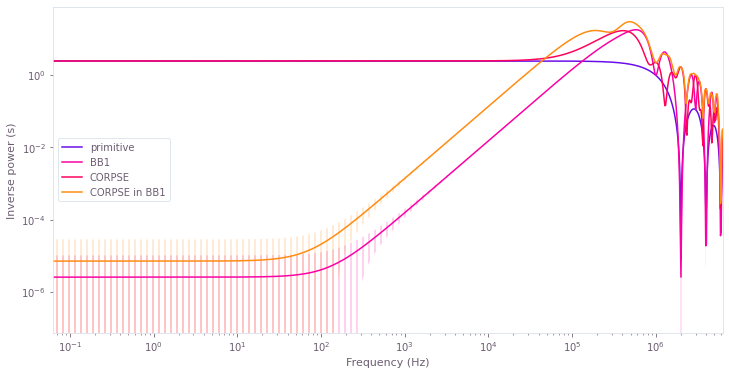

In [4]:
plot_filter_functions(
    plt.figure(),
    {
        scheme: [
            asdict(sample)
            for sample in scheme_objects["amplitude_filter_function"].samples
        ]
        for scheme, scheme_objects in schemes.items()
    },
)

#### Dephasing noise

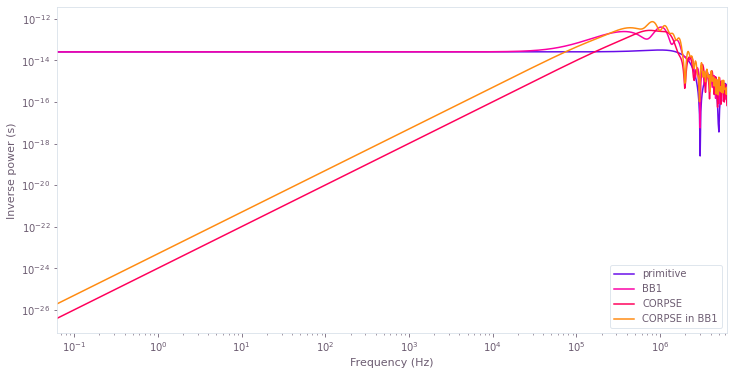

In [5]:
plot_filter_functions(
    plt.figure(),
    {
        scheme: [
            asdict(sample)
            for sample in scheme_objects["dephasing_filter_function"].samples
        ]
        for scheme, scheme_objects in schemes.items()
    },
)

### Accessing the frequency domain noise operators
The frequency domain noise operators are computed as part of the filter function calculation. They are available in the result samples when the `result_scope` parameter is set appropriately. In this case we have configured the filter function calculation for the dephasing noise to include the operators.

In [6]:
print("Scheme: {}".format("primitive"))
print(
    "Frequency domain noise operator at f =",
    schemes["primitive"]["dephasing_filter_function"].samples[-1].frequency,
    " Hz:",
)
print(
    schemes["primitive"]["dephasing_filter_function"]
    .samples[-1]
    .frequency_domain_noise_operator
)

Scheme: primitive
Frequency domain noise operator at f = 6283185.307179586  Hz:
[[-1.00946617e-08-2.11765689e-08j  1.60661531e-09+3.37035562e-09j]
 [-1.60661531e-09-3.37035562e-09j  1.00946617e-08+2.11765689e-08j]]


### Calculating the infidelity with respect to noise power spectral densities

As explained in the reference documentation for [`qctrl.functions.calculate_filter_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html), the overlap integrals of the filter functions with the noise power spectral densities (PSDs) can be used to estimate the operational infidelity in the weak noise regime. 
If multiple sources of noise are present, the total infidelity $\mathcal{I}$  can be estimated by adding the contributions of each noise as represented by each filter function $\{ F_k(f) \}$ and power spectral density $\{S_k(f)\}$:

$$ \mathcal{I} \approx \sum_k \int_{-\infty}^\infty F_k (f) S_k (f) \mathrm{d}f. $$

With the filter functions we calculated previously, we can find the operational infidelity with respect to power spectral densities that we define. To do this, we just need to calculate numerically the overlap integrals, which can be done using the `np.trapz` NumPy function for composite trapezoidal rule integration.

Note that if the pulses were not capable of perfectly creating the target X gates in the absence of noise, we should add the value of the noise-free infidelity, $\mathcal{I}_0$, to the calculation of the total infidelity:

$$ \mathcal{I} \approx \mathcal{I}_0 + \sum_k \int_{-\infty}^\infty F_k (f) S_k (f) \mathrm{d}f. $$

In the case of pulses that were predefined to generate the desired gate, $\mathcal{I}_0 \approx 0$. For other cases, you can calculate their noise-free infidelity by following the instructions from the [Simulate quantum dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics#Example-Single-qubit-with-leakage) user guide.

In [7]:
# Define amplitude noise power spectral density
psd_amplitude = lambda frequency: 1e-2 / (frequency ** 2 + 1)

# Define dephasing noise power spectral density
psd_dephasing = lambda frequency: 1e12 / (frequency ** 2 + 1)

for scheme, scheme_objects in schemes.items():
    # Calculate overlap integral for amplitude noise
    frequencies = np.array(
        [
            sample.frequency
            for sample in scheme_objects["amplitude_filter_function"].samples
        ]
    )
    inverse_powers = np.array(
        [
            sample.inverse_power
            for sample in scheme_objects["amplitude_filter_function"].samples
        ]
    )
    scheme_objects["amplitude_infidelity"] = np.trapz(
        y=inverse_powers * psd_amplitude(frequencies),
        x=frequencies,
    )

    # Calculate overlap integral for dephasing noise
    frequencies = np.array(
        [
            sample.frequency
            for sample in scheme_objects["dephasing_filter_function"].samples
        ]
    )
    inverse_powers = np.array(
        [
            sample.inverse_power
            for sample in scheme_objects["dephasing_filter_function"].samples
        ]
    )
    scheme_objects["dephasing_infidelity"] = np.trapz(
        y=inverse_powers * psd_dephasing(frequencies),
        x=frequencies,
    )

    # Add contributions from the two noises
    scheme_objects["infidelity"] = (
        scheme_objects["amplitude_infidelity"] + scheme_objects["dephasing_infidelity"]
    )

    # Print results
    print("\nScheme: {}".format(scheme))
    print(
        "Infidelity due to amplitude noise: {}".format(
            scheme_objects["amplitude_infidelity"]
        )
    )
    print(
        "Infidelity due to dephasing noise: {}".format(
            scheme_objects["dephasing_infidelity"]
        )
    )
    print("Total infidelity: {}".format(scheme_objects["infidelity"]))


Scheme: primitive
Infidelity due to amplitude noise: 0.03723654337985449
Infidelity due to dephasing noise: 0.03820153063186018
Total infidelity: 0.07543807401171468

Scheme: BB1
Infidelity due to amplitude noise: 7.496903008518675e-07
Infidelity due to dephasing noise: 0.03820309321006108
Total infidelity: 0.03820384290036193

Scheme: CORPSE
Infidelity due to amplitude noise: 0.037320133317426
Infidelity due to dephasing noise: 7.500233450859161e-07
Total infidelity: 0.037320883340771084

Scheme: CORPSE in BB1
Infidelity due to amplitude noise: 2.835576402625074e-06
Infidelity due to dephasing noise: 2.187595520586042e-06
Total infidelity: 5.0231719232111165e-06


### Summary

The plots and infidelities show that the BB1 controls perform better against (low-frequency) amplitude noise than the primitive $\pi$-pulse, but perform just like the primitive in the case of dephasing noise. This is expected, as BB1 is one of the *control-error-compensating driven controls*. The inverse is true of the pure CORPSE controls: they perform as poorly as the primitive against amplitude noise, but perform better against (low-frequency) dephasing noise. This behavior is expected as CORPSE is a *dephasing-error-compensating driven control*. Finally, the *dephasing-and-control-error-compensating driven control* CORPSE in BB1 performs better than the primitive for low-frequencies of both noises (albeit less so than the controls specialized for one specific kind of noise).

We have thus demonstrated how the Q-CTRL Python package can be used to characterize the sensitivity of different controls to time-dependent noise channels by calculating their corresponding filter functions.